# Introduction
In this notebook, we will attempt a first analysis of the Sberbank housing dataset on Kaggle.  This analysis is inspired by a study by juliencs on the Ames housing dataset here: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset.

In [39]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import cross_val_score, train_test_split
#from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
#from scipy.stats import skew
#from IPython.display import display
import seaborn as sn
#%matplotlib inline

In [40]:
# import data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print(train.shape)
print(test.shape)

(30471, 292)
(7662, 291)


In [41]:
# view the dataframe
pd.set_option('display.max_columns', None)
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [42]:
# check for duplicates
# (a python set cannot contain duplicates)
idsUnique = len(set(train.id))
idsTotal = train.shape[0]
print('Number of entries = ', idsTotal)
print('Number of duplicates = ', idsTotal-idsUnique)
testid = list(test.id.values)
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

Number of entries =  30471
Number of duplicates =  0


# Preprocessing
Now we will look at some elementary plots, and remove outliers or entries with strange features.

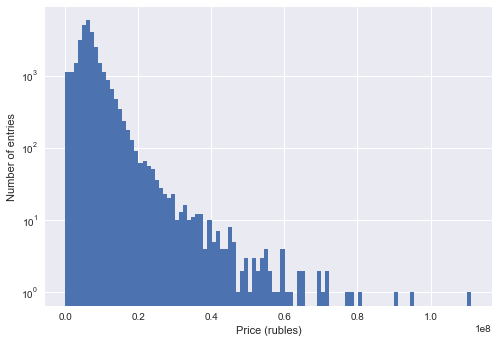

In [43]:
# histogram of prices
plt.figure()
plt.hist(train['price_doc'],bins=100)
plt.yscale('log')
plt.xlabel('Price (rubles)')
plt.ylabel('Number of entries')
plt.show()

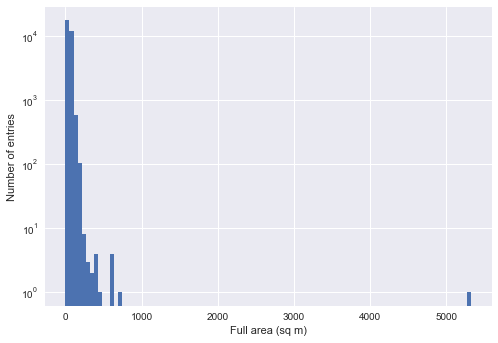

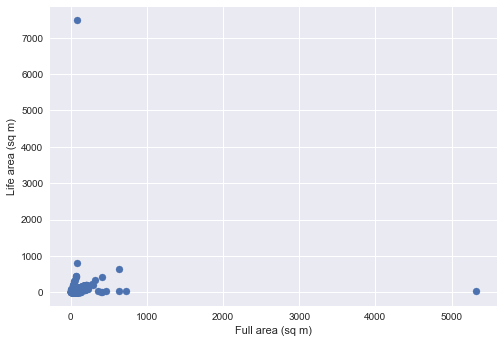

In [44]:
# area of appartment
plt.figure()
plt.hist(train['full_sq'],bins=100)
plt.yscale('log')
plt.xlabel('Full area (sq m)')
plt.ylabel('Number of entries')
plt.show()

plt.figure()
plt.scatter(train['full_sq'], train['life_sq'])
plt.xlabel('Full area (sq m)')
plt.ylabel('Life area (sq m)')
plt.show()

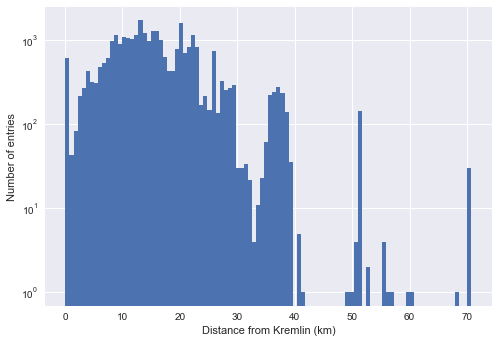

In [45]:
# distance from kremlin
plt.figure()
plt.hist(train['kremlin_km'],bins=100)
plt.yscale('log')
plt.xlabel('Distance from Kremlin (km)')
plt.ylabel('Number of entries')
plt.show()

### TODO
* Need to remove the outliers with full area or life area > 5000.
* Need to take care of entries with zero distance from Kremlin.

In [7]:
#train = train[(train['full_sq'] < 5000) & (train['life_sq'] < 5000)]

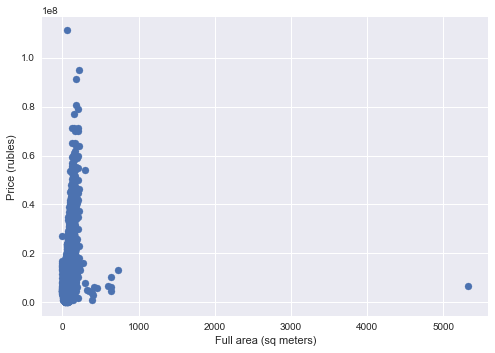

In [8]:
# price vs area
plt.figure()
plt.scatter(train['full_sq'], train['price_doc'])
plt.xlabel('Full area (sq meters)')
plt.ylabel('Price (rubles)')
plt.show()

Looks like there are three sub-classes in this plot.
    1.  Entries in the core distribution.
    2.  Entries with zero area.
    3.  Entries with large area and low price.

Let's try to remove #2.  I'm guessing #3 represents houses instead of apartments -- we can keep those in for now.

In [9]:
train.shape
train = train[(train['full_sq'] > 1)]

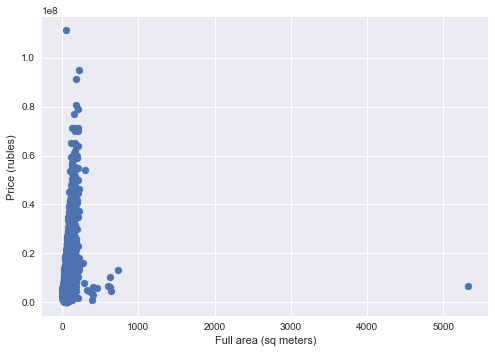

(30445, 291)

In [10]:
# price vs area (again)
plt.figure()
plt.scatter(train['full_sq'], train['price_doc'])
plt.xlabel('Full area (sq meters)')
plt.ylabel('Price (rubles)')
plt.show()

train.shape

That looks better, although it looks like we've lost about 20% of our training set...
This is probably something that we can't get around, since living area will be one of the most important features for pricing.

Let's move on for now.

In [11]:
# remove area Poselenie Klenovskoe -- does not appear in test set
train = train[train['sub_area'] != 'Poselenie Klenovskoe']
train.shape

(30444, 291)

In [12]:
# log transform of target price
# so that regression errors affect low and high prices equally
train.price_doc = np.log1p(train.price_doc)
y = train.price_doc

### Missing values
Need to take care of this...

# Features

Let us begin by finding the most important features for pricing.

In [13]:
print('Corelation with price:')
corr = train.corr()
corr.sort_values(['price_doc'], ascending=False, inplace=True)
print(corr.price_doc)

Corelation with price:
price_doc                         1.000000
num_room                          0.428751
full_sq                           0.272288
trc_count_5000                    0.227806
sport_count_5000                  0.223144
sport_count_3000                  0.219242
sport_count_2000                  0.212982
trc_sqm_5000                      0.209875
sport_count_1500                  0.198164
sport_objects_raion               0.196062
trc_count_3000                    0.194766
office_sqm_5000                   0.193576
trc_sqm_3000                      0.178245
school_education_centers_raion    0.173900
cafe_count_5000_price_1000        0.169232
market_count_5000                 0.162300
office_sqm_3000                   0.161513
cafe_count_5000_price_1500        0.160785
cafe_count_5000                   0.160350
cafe_count_5000_na_price          0.159213
ekder_male                        0.158966
cafe_count_5000_price_500         0.157669
trc_count_2000                 

Create year/month/day features using the timestamp:

In [14]:
train['time_year'] = train['timestamp']
train['time_month'] = train['timestamp']
train['time_day'] = train['timestamp']
train['time_year'] = train['time_year'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
train['time_month'] = train['time_month'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
train['time_day'] = train['time_day'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

test['time_year'] = test['timestamp']
test['time_month'] = test['timestamp']
test['time_day'] = test['timestamp']
test['time_year'] = test['time_year'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
test['time_month'] = test['time_month'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
test['time_day'] = test['time_day'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

Separate features into numerical and categorical:
#### TODO:
Check that numerical and categorical features are correct.

In [15]:
categorical_features = train.select_dtypes(include = ['object']).columns
categorical_features = categorical_features.drop('timestamp')
numerical_features = train.select_dtypes(exclude = ['object']).columns
numerical_features = numerical_features.drop('price_doc')
print('Numerical features : ' + str(len(numerical_features)))
print('Categorical features : ' + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

print('List of categorical features:')
print(categorical_features.values)

# do the same for the test set
categorical_featurest = test.select_dtypes(include = ['object']).columns
categorical_featurest = categorical_featurest.drop('timestamp')
numerical_featurest = test.select_dtypes(exclude = ['object']).columns
test_num = test[numerical_featurest]
test_cat = test[categorical_featurest]

Numerical features : 277
Categorical features : 15
List of categorical features:
['product_type' 'sub_area' 'culture_objects_top_25'
 'thermal_power_plant_raion' 'incineration_raion' 'oil_chemistry_raion'
 'radiation_raion' 'railroad_terminal_raion' 'big_market_raion'
 'nuclear_reactor_raion' 'detention_facility_raion' 'water_1line'
 'big_road1_1line' 'railroad_1line' 'ecology']


In [16]:
# for NaN's, fill with the median value
print("NAs for numerical features in train (before): " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("NAs for numerical features in train (after): " + str(train_num.isnull().values.sum()))

NAs for numerical features in train (before): 260733
NAs for numerical features in train (after): 0


In [17]:
print("NAs for categorical features in train: " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train: 0


In [18]:
# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat)

# test set
test_num = test_num.fillna(test_num.median())
test_cat = pd.get_dummies(test_cat)

In [19]:
print('Number of numerical features in train: ', len(train_num.columns))
print('Number of categorical features in train: ', len(train_cat.columns))

Number of numerical features in train:  277
Number of categorical features in train:  176


# Modeling

Let's try a simple linear regression.

In [20]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("Number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

Number of features : 453
X_train : (21310, 453)
X_test : (9134, 453)
y_train : (21310,)
y_test : (9134,)


### TODO:
Standardize numerical features.

In [21]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

### Linear regression without regularization

/usr/local/lib/python3.4/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


RMSE on Training set : 0.553413279841
RMSE on Test set : 1.31346488717


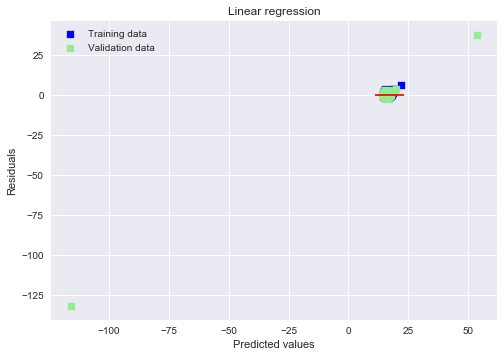

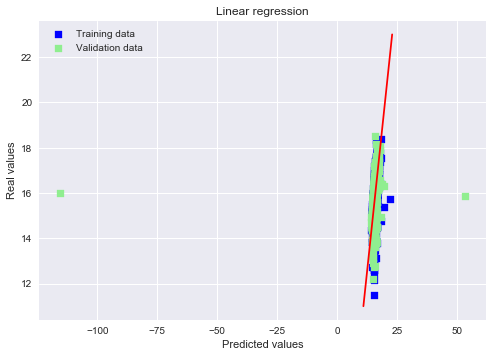

In [22]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 11, xmax = 23, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11, 23], [11, 23], c = "red")
plt.show()

# Result: Linear regression

In [23]:
# Join categorical and numerical features
test = pd.concat([test_num, test_cat], axis = 1)

# compute the results
test['price_doc'] = lr.predict(test)

result = pd.DataFrame(testid,columns=['id'])
result['price_doc'] = np.exp(test['price_doc'])
print(result.head())

      id     price_doc
0  30474  5.174156e+06
1  30475  5.176061e+01
2  30476  6.047759e+06
3  30477  8.898883e+06
4  30478  6.183180e+06


In [24]:
# output to csv
result.to_csv('../results/submission_linreg.csv', index=False)

# Attempt at XGB
Inspired by https://www.kaggle.com/viveksrinivasan/eda-focus-on-missing-values-and-simple-xgb.

In [25]:
import xgboost as xgb

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=50, show_stdv=False)

[0]	train-rmse:14.3623	test-rmse:14.3623
[50]	train-rmse:1.2011	test-rmse:1.20972
[100]	train-rmse:0.43539	test-rmse:0.479068
[150]	train-rmse:0.405029	test-rmse:0.468236
[200]	train-rmse:0.387914	test-rmse:0.467507
[250]	train-rmse:0.372958	test-rmse:0.468031


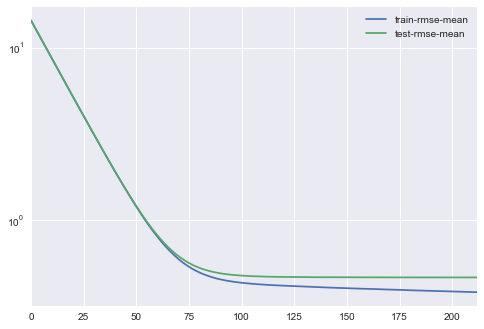

In [26]:
plt.figure()
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.yscale('log')
plt.show()

In [27]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

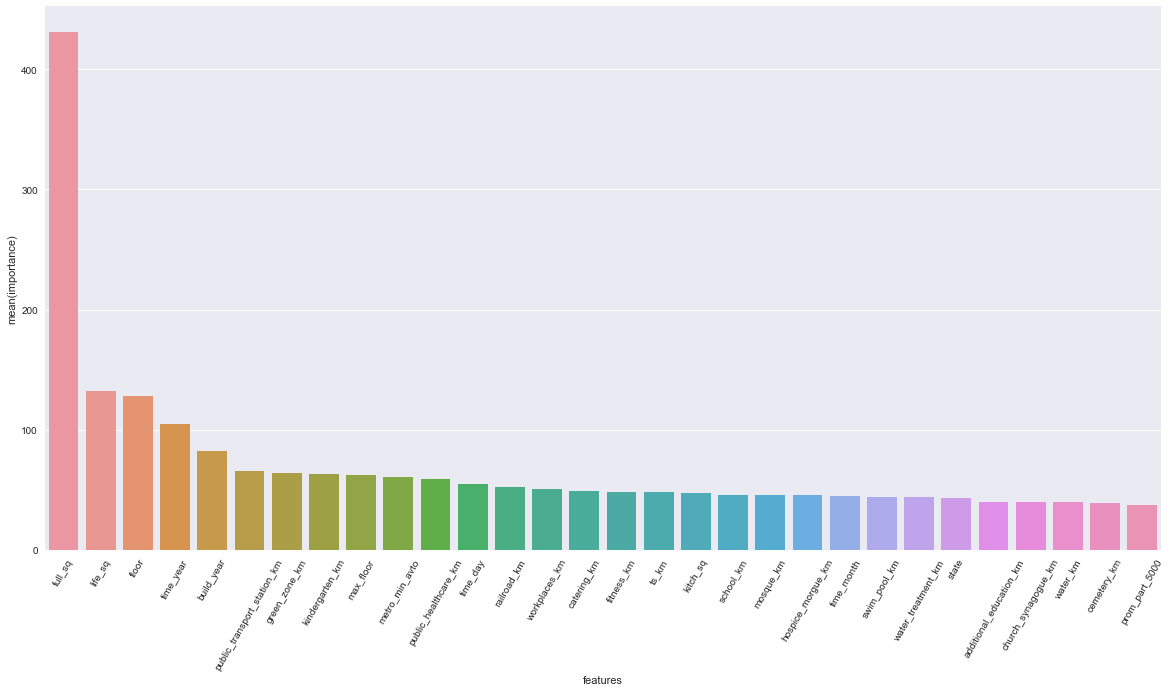

In [28]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
plt.figure()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sn.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")
plt.show()

# Results: XGB

In [29]:
# Join categorical and numerical features
testxgb = pd.concat([test_num, test_cat], axis = 1)

dtestxgb = xgb.DMatrix(testxgb)

# compute the results
testxgb['price_doc'] = model.predict(dtestxgb)

resultxgb = pd.DataFrame(testid,columns=['id'])
resultxgb['price_doc'] = np.exp(testxgb['price_doc'])
print(resultxgb.head())

      id  price_doc
0  30474  5570047.5
1  30475  8245291.0
2  30476  5023670.0
3  30477  5960404.5
4  30478  5379397.5


In [30]:
# output to csv
resultxgb.to_csv('../results/submission_xgb.csv', index=False)